In [2]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import pandas as pd 
import matplotlib.pyplot as plt      
import torch
import seaborn as sns

# Necessary functions to preprocess the data, get the features and plot them


In [42]:
# initial dataframe
def pre_process(data_path,timestamps=None,normalize=False):
    data=pd.read_excel(data_path)
    # print("The RAW DATA info is:")
    # data.info()

    #preprocessing to get it in my order
    df=data.copy() #copying it so original data is not affected
    df=df.dropna()
    df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
    df=df.rename({
        "Time - Current":"Time",
        "Current (kA) - Current":"Current (kA)",
        "Voltage (V) - Voltage":"Voltage (V)",
        "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
        "Force (kg) - Force":"Force (kgf)"
    },axis=1)

    if normalize:
        df=(df-df.mean())/df.std()
        return df
    elif timestamps is not None:
        df=df.loc[timestamps]
        return df
    else:
        return df
    # print("\n the formatted data info is: ")
    # df.info()

In [4]:

def get_features(sensor,timestamps=None,spotf=1,spotl=69,normalize=False):
    feature_list={'mean':[],
                'median':[],
                'mode':[],
                'std':[],
                'max':[],
                "min":[],
                # "skew":[],
                # "kurt":[],
                "q_25":[],
                "q_50":[],
                "q_75":[],
                # "cov":[],
                "peaks":[]
                }
    for i in range(spotf,spotl,1):
        data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
        df=pre_process(data_path,timestamps=timestamps,normalize=normalize)
        signal=np.array(df[sensor])
        signal_norm=(signal-np.mean(signal))/np.std(signal)

        feature_list["mean"].append(np.round(np.mean(signal),4))
        feature_list['median'].append(np.round(np.median(signal),4))
        feature_list['mode'].append(np.round(stats.mode(signal, keepdims=True)[0][0],4))
        feature_list['std'].append(np.round(np.std(signal),4))
        feature_list['max'].append(np.round(np.max(signal),4))
        feature_list['min'].append(np.round(np.min(signal),4))
        # feature_list['skew'].append(np.round(stats.skew(signal),4))
        # feature_list['kurt'].append(np.round(stats.kurtosis(signal),4))
        feature_list['q_25'].append(np.round(np.percentile(signal, [25]),4))
        feature_list['q_50'].append(np.round(np.percentile(signal, [50]),4))
        feature_list['q_75'].append(np.round(np.percentile(signal, [75]),4))
        # feature_list['cov'].append(np.round(np.std(signal) / np.mean(signal),4))
        peaks, _ = find_peaks(signal)
        feature_list['peaks'].append(len(peaks))

    return feature_list


In [5]:
def plot_features(dataframe,sensor,features,trend=True,deg=1):
    n_features=len(dataframe.columns)
    n_cols=3
    n_rows=-(-n_features//n_cols)

    fig, axes= plt.subplots(n_rows,n_cols, figsize=(60,6*n_rows))
    axes=axes.flatten()
    plt.suptitle(f"Extracted features of {sensor}",fontsize=16)

    for i, feature in enumerate(features):
        axes[i].plot(dataframe.index,dataframe[feature],'o-',label=f'{sensor} {feature}')
        axes[i].set_title(f"{sensor} {feature}")
        axes[i].set_xlabel("Spot No.")
        axes[i].set_ylabel(f"{feature} (Ohm)")
        axes[i].grid(True)
        axes[i].set_xticks(np.arange(1,dataframe.shape[0]+1,1))
        if trend:
            coeffs = np.polyfit(dataframe.index,dataframe[feature] , deg=deg)
            trendline = np.polyval(coeffs, dataframe.index)
            axes[i].plot(dataframe.index, trendline, color='red', label='Linear Trendline',linestyle='dashed')
        axes[i].legend()

    for j in range(i+1,len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Here we can call for features instance and next plot them


In [5]:
# extracting all the statistical features for each sensor
feature_list_Resistance=get_features(sensor="Resistance (Ohm)",spotf=1,spotl=69,normalize=False)
feature_list_Force=get_features(sensor="Force (kgf)",spotf=1,spotl=69,normalize=False)
feature_list_Current=get_features(sensor="Current (kA)",spotf=1,spotl=69,normalize=False)
feature_list_Voltage=get_features(sensor='Voltage (V)',spotf=1,spotl=69,normalize=False)

# creating respective dataframes

df_Resistance=pd.DataFrame(feature_list_Resistance,columns=feature_list_Resistance.keys())
# #normalizing features
# df_Resistance= (df_Resistance - df_Resistance.mean()) / df_Resistance.std()
df_Resistance.index = range(1, len(df_Resistance) + 1)

df_Current=pd.DataFrame(feature_list_Current,columns=feature_list_Current.keys())
# #normalizing features
# df_Current= (df_Current - df_Current.mean()) / df_Current.std()
df_Current.index = range(1, len(df_Current) + 1)

df_Force=pd.DataFrame(feature_list_Force,columns=feature_list_Force.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Force.index = range(1, len(df_Force) + 1)

df_Voltage=pd.DataFrame(feature_list_Voltage,columns=feature_list_Voltage.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Voltage.index = range(1, len(df_Voltage) + 1)




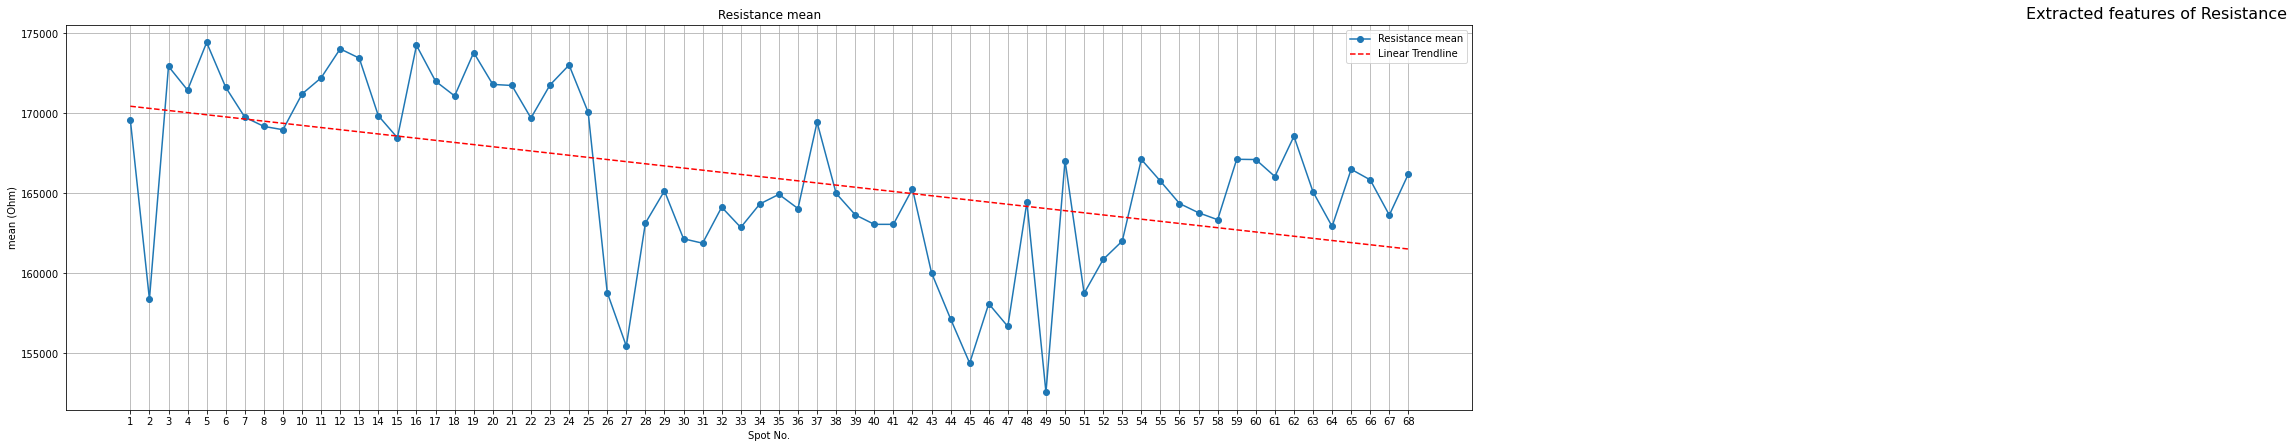

In [50]:
# plotting extracted features for each sensor
plot_features(dataframe=df_Resistance,sensor="Resistance",features=['mean'],trend=True,deg=1)

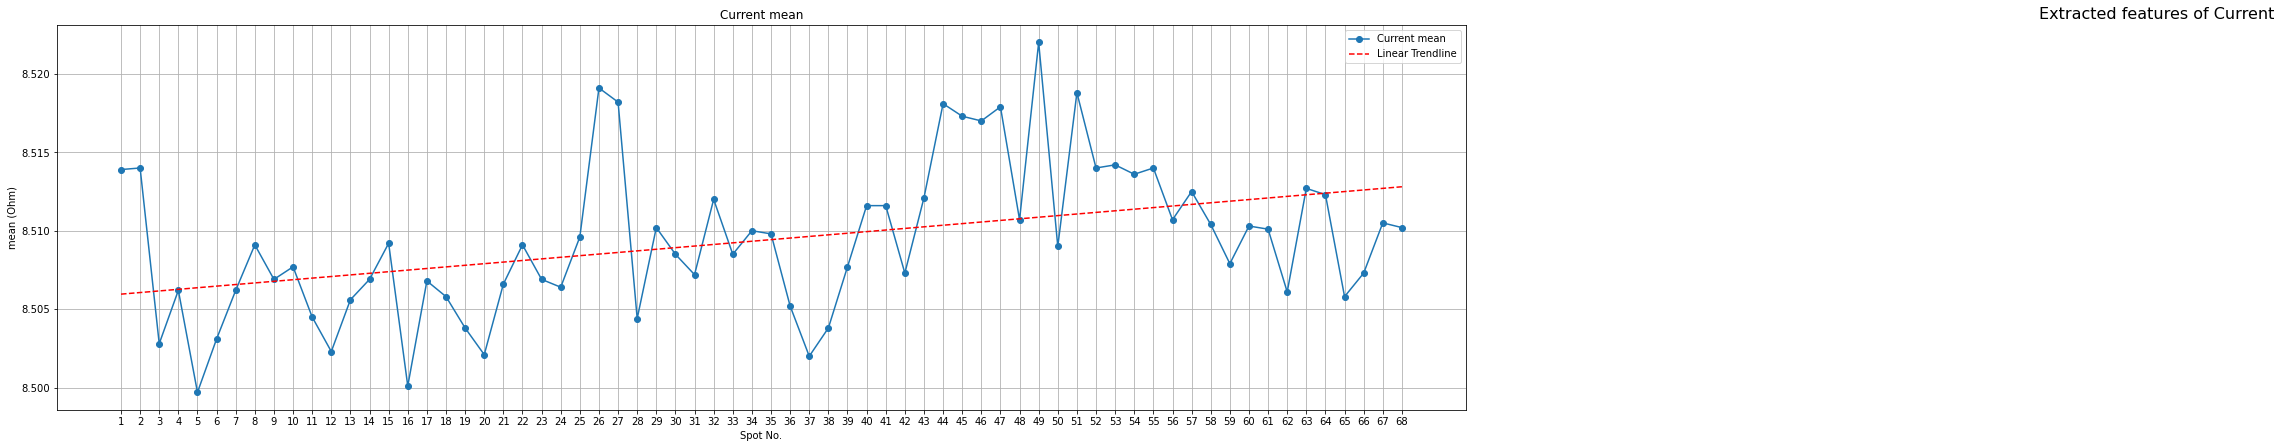

In [51]:
plot_features(dataframe=df_Current,sensor="Current",features=['mean'],trend=True,deg=1)

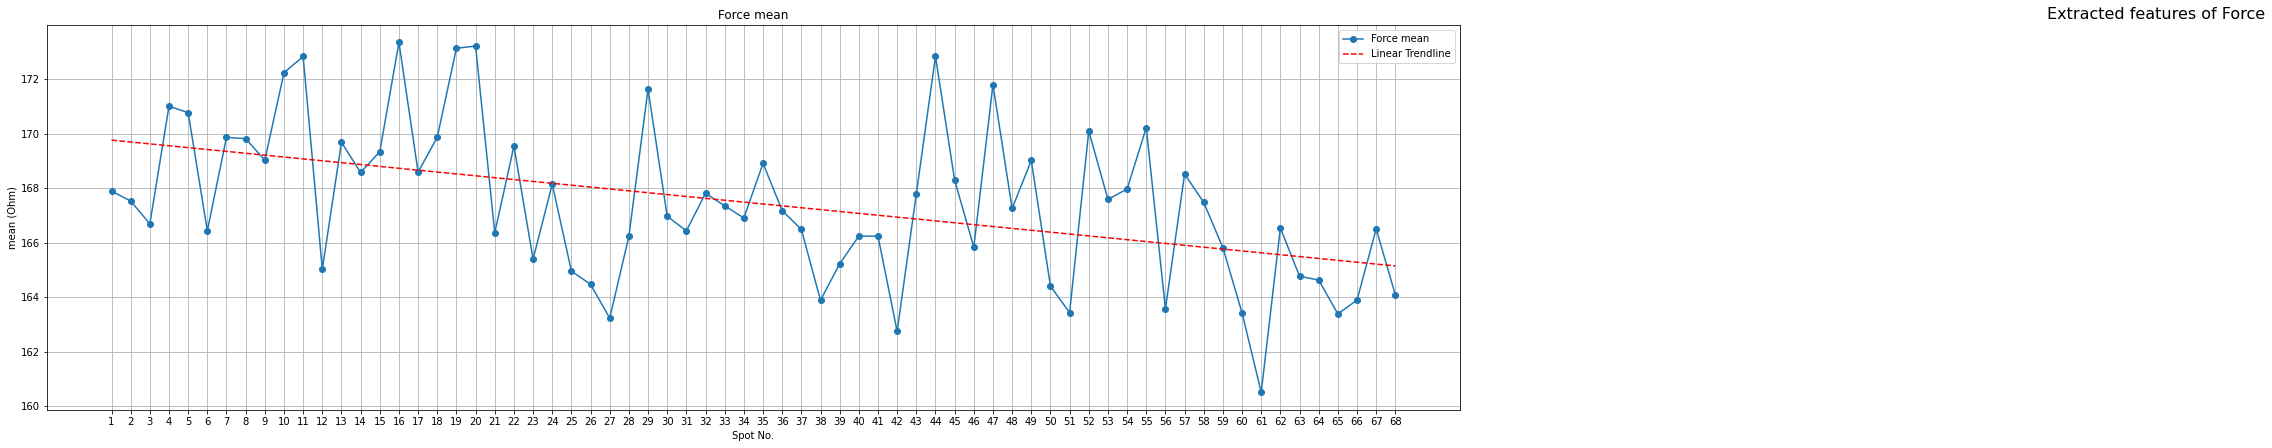

In [52]:
plot_features(dataframe=df_Force,sensor='Force',features=['mean'],trend=True,deg=1)

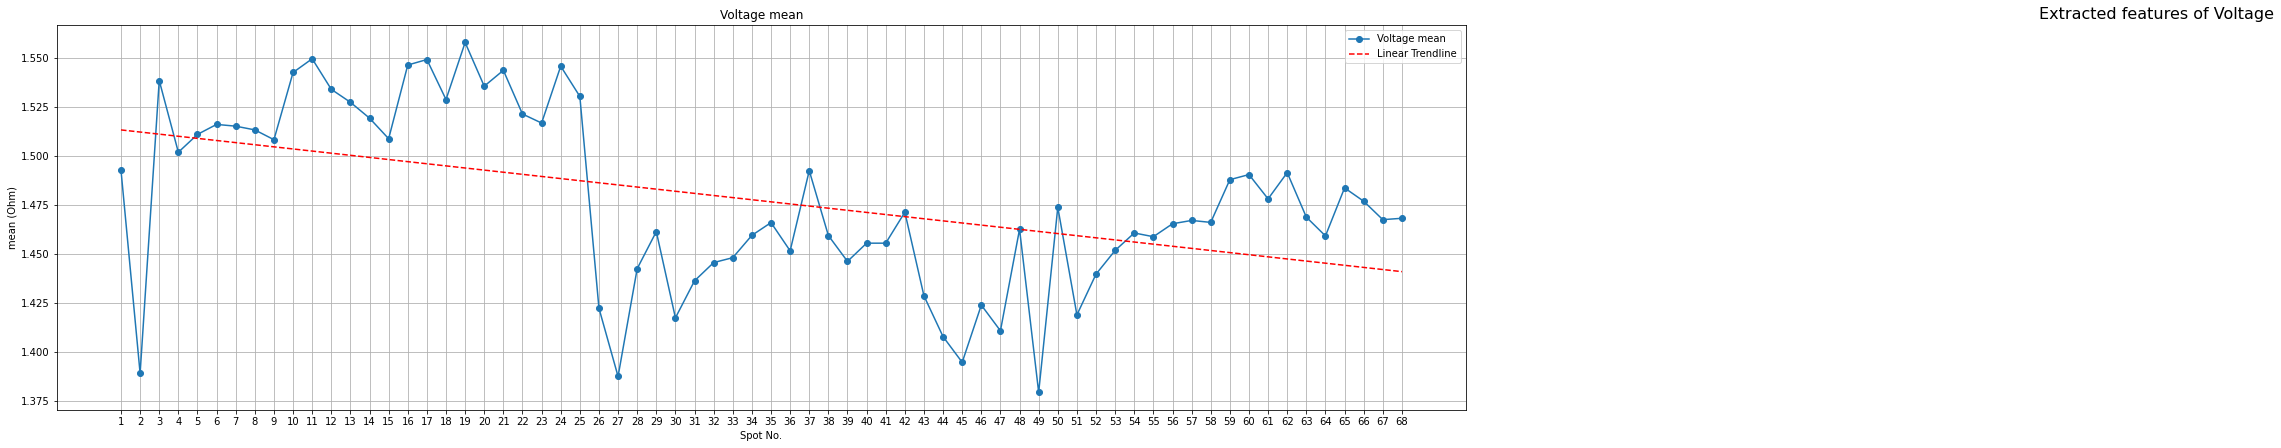

In [53]:
plot_features(dataframe=df_Voltage,sensor='Voltage',features=['mean'],deg=1,trend=True)

In [11]:
print(f"The Pearson correlation coefficents:")
print(f"\nResistance mean and Current mean: {df_Resistance['mean'].corr(df_Current['mean']):.4f}")
print(f"\nResistance mean and Voltage mean: {df_Resistance['mean'].corr(df_Voltage['mean']):.4f}")
print(f"\nResistance mean and Force mean: {df_Resistance['mean'].corr(df_Force['mean']):.4f}")
print(f"\nCurrent mean and Force mean: {df_Current['mean'].corr(df_Force['mean']):.4f}")


The Pearson correlation coefficents:

Resistance mean and Current mean: -0.8269

Resistance mean and Voltage mean: 0.9611

Resistance mean and Force mean: 0.2468

Current mean and Force mean: -0.1458


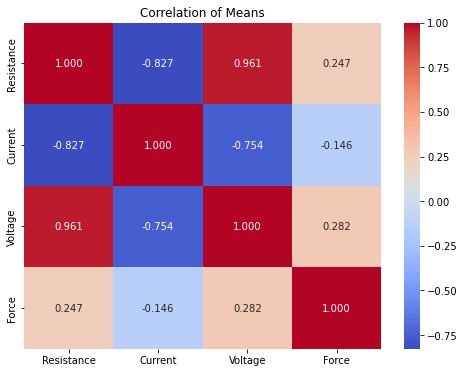

In [58]:
df_combined = pd.DataFrame({
    'Resistance': df_Resistance['mean'],
    'Current': df_Current['mean'],
    'Voltage': df_Voltage['mean'],
    'Force': df_Force['mean']
})

# Compute the correlation matrix
corr = df_combined.corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation of Means')
plt.show()

In [133]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt

def segment_signal(df, feature_cols=['mean', 'std'], signal_name='resistance', model='rbf', pen=10, plot=True):
    """
    Applies change point detection to a signal DataFrame and returns segmented DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with statistical features per spot.
        feature_cols (list): Features to use for change point detection (e.g., ['mean', 'std']).
        signal_name (str): Name of the signal (resistance/force/current).
        model (str): Change point detection model ('rbf', 'l2', etc.).
        pen (int/float): Penalty parameter for sensitivity.
        plot (bool): Whether to show plot with change points.
        
    Returns:
        df_segmented (pd.DataFrame): Original df with added 'segment_id' column.
        change_points (list): List of change point indices.
    """
    signal = df[feature_cols].values
    algo = rpt.Pelt(model=model).fit(signal)
    change_points = algo.predict(pen=pen)

    # Assign segment ID to each row
    segment_ids = np.zeros(len(df), dtype=int)
    prev_cp = 0
    for i, cp in enumerate(change_points):
        segment_ids[prev_cp:cp] = i
        prev_cp = cp

    df_segmented = df.copy()
    df_segmented['segment_id'] = segment_ids

    if plot:
        rpt.display(signal, change_points, figsize=(12, 4))
        plt.title(f"Change Point Detection - {signal_name.capitalize()} ({model}, pen={pen})")
        plt.xlabel("Spot Index")
        plt.ylabel("Feature Value(s)")
        plt.grid(True)
        plt.show()

    print(f"Detected {len(change_points)-1} segments in {signal_name} using model '{model}'")
    return df_segmented, change_points


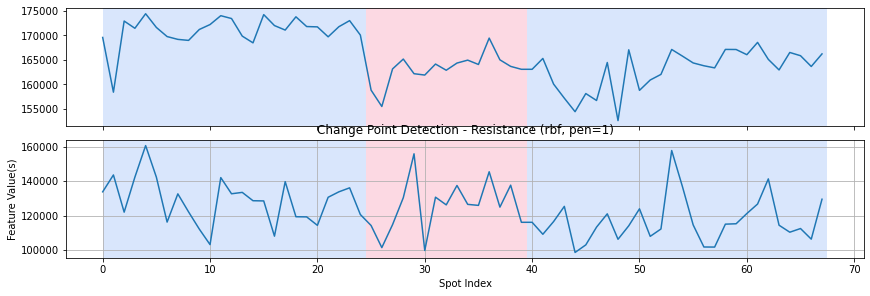

Detected 2 segments in resistance using model 'rbf'


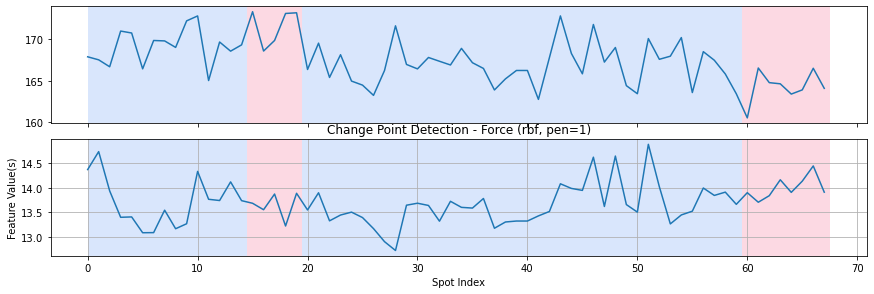

Detected 3 segments in force using model 'rbf'


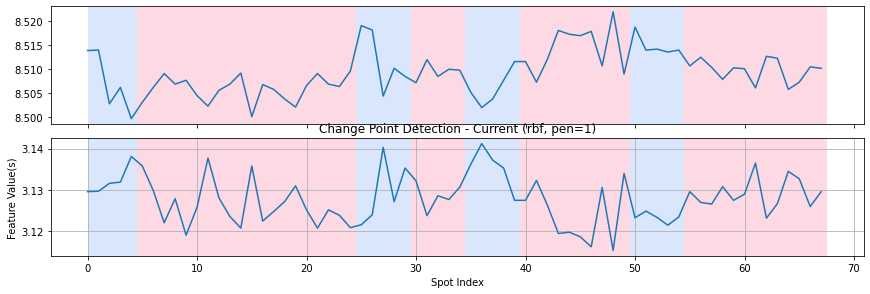

Detected 7 segments in current using model 'rbf'


In [143]:
# Resistance segmentation
df_res_segmented, cp_res = segment_signal(df_Resistance, feature_cols=['mean', 'std'], signal_name='resistance', pen=1)

# Force segmentation
df_force_segmented, cp_force = segment_signal(df_Force, feature_cols=['mean', 'std'], signal_name='force', pen=1)

# Current segmentation
df_current_segmented, cp_current = segment_signal(df_Current, feature_cols=['mean', 'std'], signal_name='current', pen=1)


In [141]:
df_res_segmented['segment_id'].unique()

array([0, 1, 2])

# Space for rough


In [6]:
data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
data=pd.read_excel(data_path)
# print("The RAW DATA info is:")
# data.info()

#preprocessing to get it in my order
df=data.copy() #copying it so original data is not affected
df=df.dropna()
df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
df=df.rename({
    "Time - Current":"Time",
    "Current (kA) - Current":"Current (kA)",
    "Voltage (V) - Voltage":"Voltage (V)",
    "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
    "Force (kg) - Force":"Force (kgf)"
},axis=1)

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import ruptures as rpt

# # Function to apply PELT change point detection on a given DataFrame
# def detect_change_points(df, feature_name='resistance', pen=10, show_std=False):
#     # Use mean or combine mean + std for richer signal
#     signal = df[['mean', 'std']].values if show_std else df[['mean']].values

#     # Initialize and fit model
#     model = rpt.Pelt(model="rbf").fit(signal)
#     change_points = model.predict(pen=pen)

#     # Plot results
#     rpt.display(signal, change_points, figsize=(10, 5))
#     plt.title(f"Change Point Detection: {feature_name.capitalize()} (penalty={pen})")
#     plt.xlabel("Spot Index")
#     plt.ylabel("Signal Value" + ("s" if show_std else ""))
#     plt.grid(True)
#     plt.show()

#     print(f"Detected change points for {feature_name}: {change_points}")
#     return change_points

# # Run CPD on all three signals
# cp_resistance = detect_change_points(df_Resistance, feature_name='resistance', pen=20, show_std=True)
# cp_current = detect_change_points(df_Current, feature_name='current', pen=20, show_std=True)
# cp_force = detect_change_points(df_Force, feature_name='force', pen=20, show_std=True)


In [122]:
import matplotlib.pyplot as plt
import numpy as np

def plot_electrode_health(df_resistance):
    # Data
    x = np.arange(1, len(df_resistance) + 1)
    y = df_resistance['mean'].values

    # Linear trendline
    coeffs = np.polyfit(x, y, deg=1)
    trendline = np.polyval(coeffs, x)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'o-', label='Mean Resistance')
    plt.plot(x, trendline, 'r--', label='Linear Trend (Wear Pattern)')
    plt.title('Electrode Health Curve - Resistance Over Spots')
    plt.xlabel('Spot Number')
    plt.ylabel('Mean Resistance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Trendline Equation: R = {coeffs[0]:.3f} * Spot + {coeffs[1]:.2f}")


In [49]:
path1=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
path11=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{11}.xlsx"
path24=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{24}.xlsx"
path28=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{28}.xlsx"
path34=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{34}.xlsx"
path50=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{50}.xlsx"
path67=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{67}.xlsx"

time=np.arange(0,765,25)


df1=pre_process(data_path=path1,timestamps=None)
df11=pre_process(data_path=path11,timestamps=None)
df24=pre_process(data_path=path24,timestamps=None)
df28=pre_process(data_path=path28,timestamps=None)
df34=pre_process(data_path=path34,timestamps=None)
df50=pre_process(data_path=path50,timestamps=None)
df67=pre_process(data_path=path67,timestamps=None)









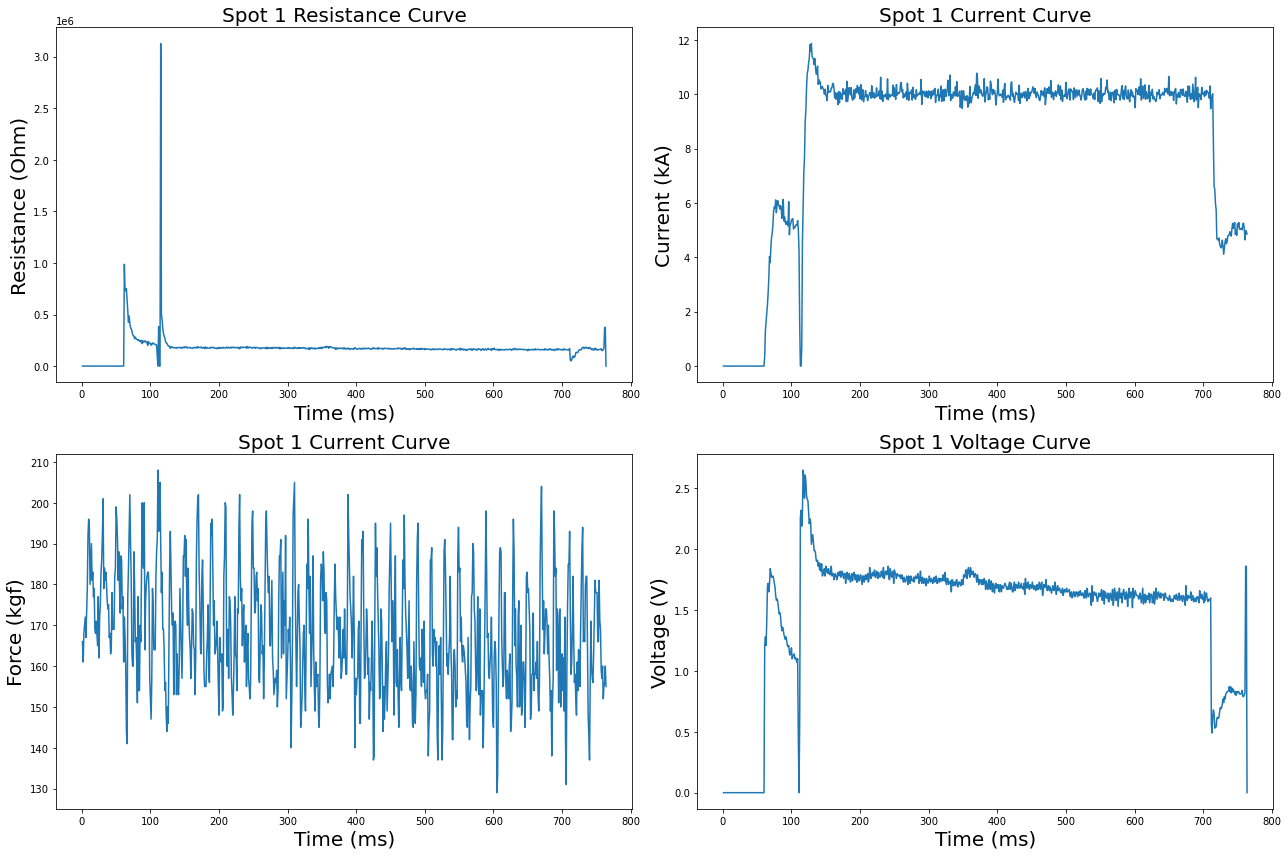

In [57]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(df1["Time"],df1["Resistance (Ohm)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Spot 1 Resistance Curve",fontsize=20)

plt.subplot(2,2,2)
plt.plot(df1["Time"],df1["Current (kA)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Current (kA)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,3)
plt.plot(df1["Time"],df1["Force (kgf)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Force (kgf)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,4)
plt.plot(df1["Time"],df1["Voltage (V)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Voltage (V)",fontsize=20)
plt.title("Spot 1 Voltage Curve",fontsize=20)

# plt.subplot(3,3,5)
# plt.plot(df50["Time"],df50["Resistance (Ohm)"])
# plt.xlabel("Time (ms)")
# plt.ylabel("Resistance (Ohm)")
# plt.title("Spot 50 Resistance Curve")

# plt.subplot(3,3,6)
# plt.plot(df67["Time"],df67["Resistance (Ohm)"])
# plt.xlabel("Time (ms)")
# plt.ylabel("Resistance (Ohm)")
# plt.title("Spot 67 Resistance Curve")

plt.tight_layout()
plt.show()



In [38]:
df1["Time"].iloc[-1]

764.0

In [ ]:
def plot_corr_heatmap(df, signal_name='Resistance'):
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    plt.title(f'{signal_name} Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Example Usage
corr_resistance = plot_corr_heatmap(df_Resistance, signal_name='Resistance')
corr_force = plot_corr_heatmap(df_Force, signal_name='Force')
corr_current = plot_corr_heatmap(df_Current, signal_name='Current')